In [1]:
import numpy as np 
import pandas as pd 
import numpy as np
import gym
from gym import wrappers
import time
import sys
import matplotlib.pyplot as plt
from hiive.mdptoolbox.mdp import QLearning
import mdptoolbox, mdptoolbox.example

## Utility Function

In [2]:
def evaluate_policy(P, R, policy, test_count=100, gamma=0.9):
    num_state = P.shape[-1]
    total_episode = num_state * test_count
    # start in each state
    total_reward = 0
    for state in range(num_state):
        state_reward = 0
        for state_episode in range(test_count):
            episode_reward = 0
            disc_rate = 1
            while True:
                # take step
                action = policy[state]
                # get next step using P
                probs = P[action][state]
                candidates = list(range(len(P[action][state])))
                next_state =  np.random.choice(candidates, 1, p=probs)[0]
                # get the reward
                reward = R[state][action] * disc_rate
                episode_reward += reward
                # when go back to 0 ended
                disc_rate *= gamma
                if next_state == 0:
                    break
            state_reward += episode_reward
        total_reward += state_reward
    return total_reward / total_episode

In [3]:
def run_Forest_policy_iteration(states, test_count):
    print('POLICY ITERATION WITH FOREST MANAGEMENT ' + str(states) + ' STATES')
    P, R = mdptoolbox.example.forest(S=states)
    value_f = [0]*10
    policy = [0]*10
    iters = [0]*10
    time_array = [0]*10
    gamma_arr = [0] * 10
    for i in range(0,10):
        pi = mdptoolbox.mdp.PolicyIteration(P, R, (i+0.5)/10)
        pi.run()
        gamma_arr[i]=(i+0.5)/10
        value_f[i] = np.mean(pi.V)
        policy[i] = pi.policy
        iters[i] = pi.iter
        time_array[i] = pi.time

    # print('Forest Management ' + str(states) + ' states - Policy Iteration Policy')
    # print(policy)

    plt.plot(gamma_arr, time_array)
    plt.xlabel('Gammas')
    plt.title('Forest Management ' + str(states) + ' states - Policy Iteration - Execution Time Analysis')
    plt.ylabel('Execution Time (s)')
    plt.grid()
    plt.show()

    
    plt.plot(gamma_arr,value_f)
    plt.xlabel('Gammas')
    plt.ylabel('Average Rewards')
    plt.title('Forest Management ' + str(states) + ' states  - Policy Iteration - Reward Analysis')
    plt.grid()
    plt.show()

    plt.plot(gamma_arr,iters)
    plt.xlabel('Gammas')
    plt.ylabel('Iterations to Converge')
    plt.title('Forest Management ' + str(states) + ' states  - Policy Iteration - Convergence Analysis')
    plt.grid()
    plt.show()

In [4]:
def run_Forest_value_iteration(states, test_count):
    print('VALUE ITERATION WITH FOREST MANAGEMENT ' + str(states) + ' STATES ')
    P, R = mdptoolbox.example.forest(S=states)
    value_f = [0]*10
    policy = [0]*10
    iters = [0]*10
    time_array = [0]*10
    gamma_arr = [0] * 10
    for i in range(0,10):
        pi = mdptoolbox.mdp.ValueIteration(P, R, (i+0.5)/10)
        pi.run()
        gamma_arr[i]=(i+0.5)/10
        value_f[i] = np.mean(pi.V)
        policy[i] = pi.policy
        iters[i] = pi.iter
        time_array[i] = pi.time

    # print('Forest Management ' + str(states) + ' states - Value Iteration Policy')
    # print(policy)
    
    plt.plot(gamma_arr, time_array)
    plt.xlabel('Gammas')
    plt.title('Forest Management ' + str(states) + ' states  - Value Iteration - Execution Time Analysis')
    plt.ylabel('Execution Time (s)')
    plt.grid()
    plt.show()
    
    plt.plot(gamma_arr,value_f)
    plt.xlabel('Gammas')
    plt.ylabel('Average Rewards')
    plt.title('Forest Management ' + str(states) + ' states  - Value Iteration - Reward Analysis')
    plt.grid()
    plt.show()

    plt.plot(gamma_arr,iters)
    plt.xlabel('Gammas')
    plt.ylabel('Iterations to Converge')
    plt.title('Forest Management ' + str(states) + ' states  - Value Iteration - Convergence Analysis')
    plt.grid()
    plt.show()

In [5]:
def trainQLearning(P, R, test_count, discount=0.9, alpha_dec=[1], alpha_min=[0.001], 
            epsilon=[1.0], epsilon_decay=[0.99], n_iter=[1000000]):
    q_df = pd.DataFrame(columns=["Iterations", "Alpha Decay", "Alpha Min", 
                                 "Epsilon", "Epsilon Decay", "Reward",
                                 "Time", "Policy", "Value Function",
                                 "Training Rewards"])
    
    count = 0
    for i in n_iter:
        for eps in epsilon:
            for eps_dec in epsilon_decay:
                for a_dec in alpha_dec:
                    for a_min in alpha_min:
                        q = QLearning(P, R, discount, alpha_decay=a_dec, 
                                      alpha_min=a_min, epsilon=eps, 
                                      epsilon_decay=eps_dec, n_iter=i)
                        q.run()
                        reward = evaluate_policy(P, R, q.policy, test_count)
                        count += 1
                        print("{}: {}".format(count, reward))
                        st = q.run_stats
                        rews = [s['Reward'] for s in st]
                        info = [i, a_dec, a_min, eps, eps_dec, reward, 
                                q.time, q.policy, q.V, rews]
                        
                        df_length = len(q_df)
                        q_df.loc[df_length] = info
    return q_df

In [31]:
def run_Forest_Q_learning(states, test_count):
    print('Q LEARNING WITH FOREST MANAGEMENT ' + str(states) + ' STATES ')
    P, R = mdptoolbox.example.forest(S=states,p=0.01)
    eps = [0.01,0.05,0.1,0.2,0.3, 0.4]
    iters = [10000, 100000, 1000000]
    q_df = trainQLearning(P, R, test_count, discount=0.95, epsilon=eps, n_iter=iters)
    
    # print('Forest Management ' + str(states) + ' states - Q-learning Table')
    # print(q_df)
    
    fig = plt.figure()
    for frame in [q_df[(q_df.Epsilon == 0.01)], q_df[(q_df.Epsilon == 0.05)], q_df[(q_df.Epsilon == 0.1)], q_df[(q_df.Epsilon == 0.2)], q_df[(q_df.Epsilon == 0.3)], q_df[(q_df.Epsilon == 0.4)]]:
        plt.plot(frame['Iterations'], frame['Reward'])
    labels = ["epsilon=" + str(x) for x in eps]
    plt.title('Forest Management ' + str(states) + ' states - Q Learning - Constant Epsilon')
    plt.legend(labels,loc='lower right')
    plt.xlabel('Iterations')
    plt.grid()
    plt.ylabel('Reward')
    plt.show()
    
    q_df[(q_df.Iterations == 1000000)].plot(x='Epsilon', y='Time',legend=None,xlabel="Epsilon",ylabel="Time",title="Forest Management " + str(states) + " - Q Learning",grid=True)
    
    return q_df

## Experiment

POLICY ITERATION WITH FOREST MANAGEMENT 20 STATES


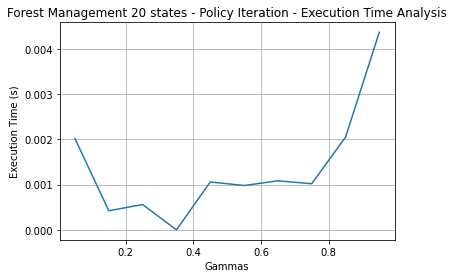

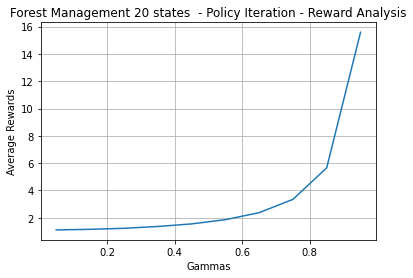

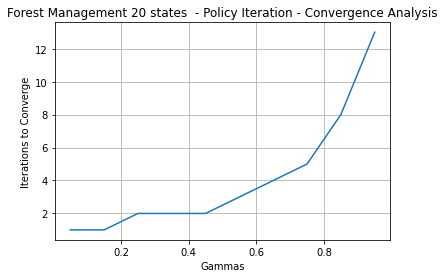

In [11]:
run_Forest_policy_iteration(20, 1000) # States, test_count

POLICY ITERATION WITH FOREST MANAGEMENT 500 STATES


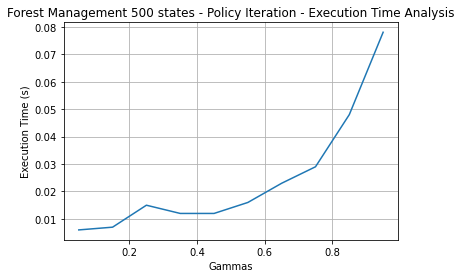

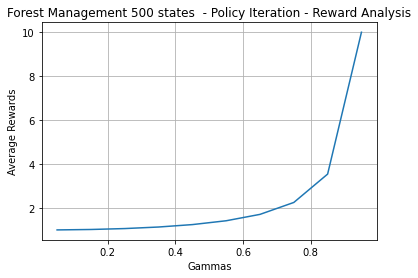

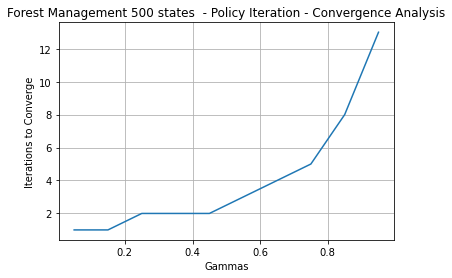

In [12]:
run_Forest_policy_iteration(500, 100) # States, test_count

VALUE ITERATION WITH FOREST MANAGEMENT 20 STATES 


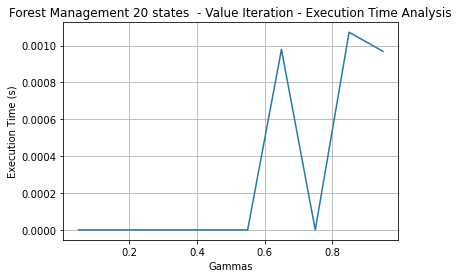

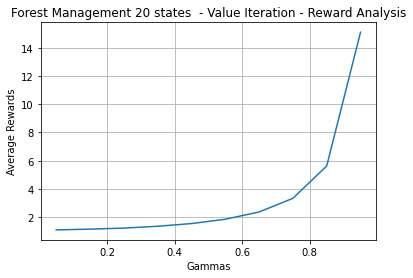

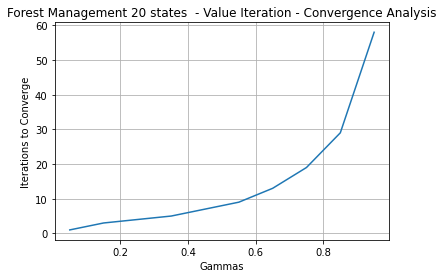

In [15]:
run_Forest_value_iteration(20, 1000) # States, test_count

VALUE ITERATION WITH FOREST MANAGEMENT 500 STATES 


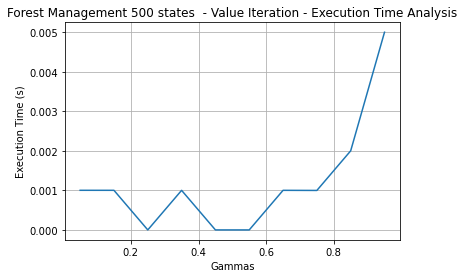

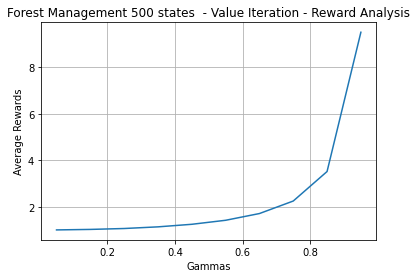

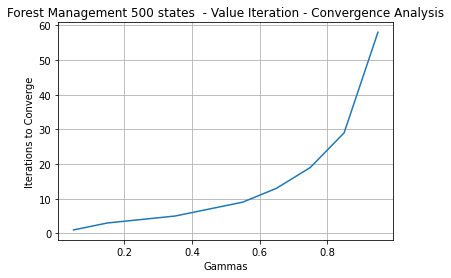

In [14]:
run_Forest_value_iteration(500, 100) # States, test_count

Q LEARNING WITH FOREST MANAGEMENT 20 STATES 
1: 2.2824157113473107
2: 2.245415849730746
3: 2.3027179662083452
4: 2.4750696634543594
5: 2.5149974615966615
6: 2.5813608324619683
7: 2.246321675711854
8: 2.2201125593430615
9: 2.3206428017078973
10: 2.2818924074637223
11: 2.484890332294954
12: 2.4854480204243297
13: 1.8237968101024447
14: 1.8407423717039584
15: 1.8423861409844255
16: 1.8226840321866293
17: 1.8243264725062578
18: 1.837297202049398
19: 1.8248624463556495
20: 1.8353029611905123
21: 1.8484958228639716
22: 1.8246569158861425
23: 1.8461754574173677
24: 1.832586889582875


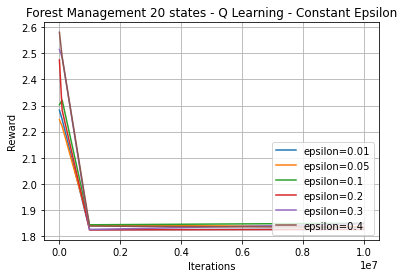

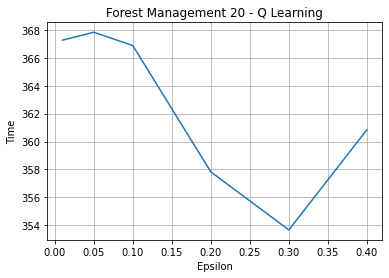

In [26]:
Q_Learning_Result_20 = run_Forest_Q_learning(20, 1000) # States, test_count

Q LEARNING WITH FOREST MANAGEMENT 20 STATES 
1: 2.2365807910094815
2: 2.321142112006449
3: 2.227820854302802
4: 2.168333510814409
5: 2.239265542469388
6: 2.247011030274974
7: 2.2839169512227744
8: 2.344311438521722
9: 2.232163218495295
10: 2.1181062346687263
11: 2.405026835151426
12: 0.65
13: 1.8246708718545994
14: 1.8550141524003012
15: 1.828252323189471
16: 1.840173266842101
17: 1.8441076339769733
18: 1.8205195582119005


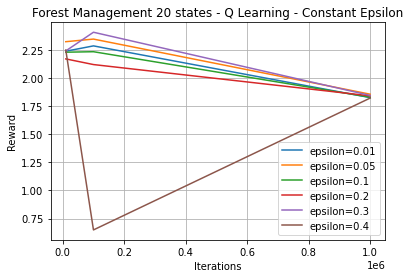

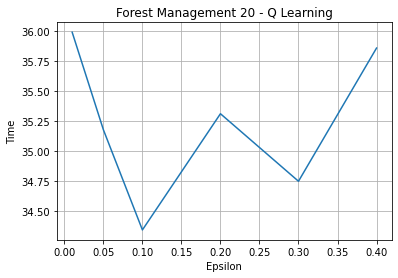

In [32]:
Q_Learning_Result_20_new = run_Forest_Q_learning(20, 1000) # States, test_count

Q LEARNING WITH FOREST MANAGEMENT 500 STATES 
1: 0.1748541438515579
2: 0.1583562118998799
3: 0.09
4: 0.17596947277024977
5: 0.1616233823439551
6: 0.1754723295264282
7: 0.414184458617053
8: 0.4024616500038008
9: 0.3901016927262885
10: 0.37934208555530435
11: 0.36771534275606355
12: 0.31
13: 0.472
14: 0.5313959259386457
15: 0.546457754757679
16: 0.5498223321082776
17: 0.484
18: 0.438


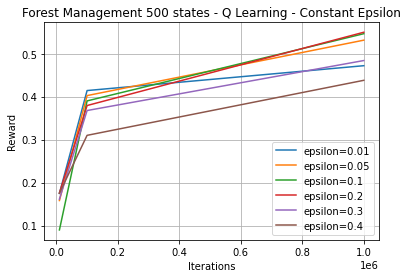

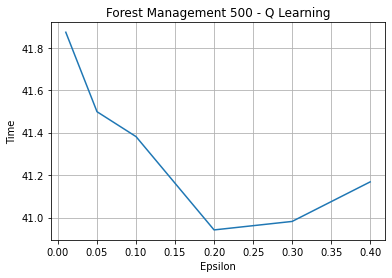

In [33]:
Q_Learning_Result_500 = run_Forest_Q_learning(500, 100) # States, test_count